Install requirements

In [1]:
!pip install tensorflow tensorflow-datasets librosa

Import libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import librosa
import numpy as np

Only grab the dataset where instument == keyboard

In [3]:
# Constants
KEYBOARD_FAMILY_LABEL = 4 # According to NSynth dataset family label
SAMPLE_RATE = 16000
TRIM_LENGTH = 3 * SAMPLE_RATE  # Trim to the first 3 seconds

def process_data(example):
    audio = example['audio']
    instrument_family = example['instrument']['family']
    pitch = example['pitch']

    is_keyboard = tf.equal(instrument_family, KEYBOARD_FAMILY_LABEL)

    def process_keyboard_sample(audio, pitch):
        audio = audio[:TRIM_LENGTH]
        if pitch < 21:
            # Instead of returning None, return a marker (e.g., a zero-length tensor)
            return tf.zeros((0,)), tf.constant(-1, dtype=tf.int64)
        else:
            pitch = pitch - 21
            return audio, pitch

    return tf.cond(is_keyboard, lambda: process_keyboard_sample(audio, pitch), lambda: (audio, pitch))

def filter_keyboard_samples(example):
    return tf.equal(example['instrument']['family'], KEYBOARD_FAMILY_LABEL)

def filter_invalid_samples(audio, pitch):
    # Check if the sample is valid (not marked for removal)
    return tf.size(audio) > 0 and tf.not_equal(pitch, -1)

def get_data_loader(data_split, batch_size=64, num_batches=None):
    ds = tfds.load('nsynth', split=data_split, as_supervised=False)

    ds = ds.filter(filter_keyboard_samples)
    ds = ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.filter(filter_invalid_samples)
    ds = ds.batch(batch_size)
    if num_batches:
        ds = ds.take(num_batches)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [4]:
# Input to model
batch_size = 32
train_loader = get_data_loader('train', batch_size, num_batches=80)
val_loader = get_data_loader('valid', batch_size, num_batches=10)
test_loader = get_data_loader('test', batch_size, num_batches=10)
classes = list(range(88))

for audio, pitch in train_loader.take(5):
    print(pitch)

Dl Completed...:   0%|          | 0/1069 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/full/2.3.3. Subsequent calls will reuse this data.
tf.Tensor(
[85 10 60 33 48 84 21 54 13 33  0  6 49 52 56 17  4 74  6 40 63 20 44 41
  7 22 67 64  8 78 16 48], shape=(32,), dtype=int64)
tf.Tensor(
[14 29 87 32 70 84 65 66 30 56 28 85 47 33 24 49 81 18 21 51 34 61 36  8
 10 45 61 70 74 33 57 52], shape=(32,), dtype=int64)
tf.Tensor(
[42 16 62 72 38 63 72 58 35 40 68 67 22  3 47 57 68 77 50 28 45 46 33 65
 30 22 10 74  5 16 81 52], shape=(32,), dtype=int64)
tf.Tensor(
[70 27 58 49 17 14 52 19 19 84 15 86 67 16 11 65 25 55 53 15 24 72 73 51
 37  6 76 24 72 13 25 41], shape=(32,), dtype=int64)
tf.Tensor(
[79 31 60 45 83 38 28 25 56  9 38 43 52 86 25 57 16 27 25 25 21 76 59 43
 46 64 43 13 85 26  7 36], shape=(32,), dtype=int64)


In [5]:
# printing a sample audio and pitch value
for audio, pitch in train_loader.take(1):
    first_sample_audio = audio[0]
    first_sample_pitch = pitch[0]

    # Calculate the maximum and minimum values
    max_value = tf.reduce_max(first_sample_audio)
    min_value = tf.reduce_min(first_sample_audio)

    # Calculate the range (max - min)
    range_value = max_value - min_value

    print(f"First sample audio max value: {max_value.numpy()}")
    print(f"First sample audio min value: {min_value.numpy()}")
    print(f"First sample audio range: {range_value.numpy()}")
    print(f"First sample pitch: {first_sample_pitch.numpy()}")

First sample audio max value: 0.46275418996810913
First sample audio min value: -0.46886491775512695
First sample audio range: 0.9316191077232361
First sample pitch: 85


In [6]:
for audio, pitch in train_loader:
  print(audio.shape)
  print(pitch.shape)
  break


(32, 48000)
(32,)


In [7]:
# get number of batches in each loader
def get_dataset_length(data_loader):
    length = 0
    for _ in data_loader:
        length += 1
    return length

# Use this function to get the length of your data loaders
test_loader_length = get_dataset_length(test_loader)
val_loader_length = get_dataset_length(val_loader)
train_loader_length = get_dataset_length(train_loader)

print(f"Train loader length: {train_loader_length}")
print(f"Validation loader length: {val_loader_length}")
print(f"Test loader length: {test_loader_length}")

Train loader length: 80
Validation loader length: 10
Test loader length: 10


In [8]:
# get number of samples in each loader
def get_dataset_sample_count(data_loader):
    total_samples = 0
    for audio, pitch in data_loader:
        # Count the number of samples in each batch
        batch_samples = tf.shape(audio)[0]  # assuming audio is a 2D tensor [batch_size, features]
        total_samples += batch_samples
    return total_samples

# Use this function to get the number of samples in your data loaders
test_samples_count = get_dataset_sample_count(test_loader)
val_samples_count = get_dataset_sample_count(val_loader)
train_samples_count = get_dataset_sample_count(train_loader)

print(f"Train loader samples: {train_samples_count}")
print(f"Validation loader samples: {val_samples_count}")
print(f"Test loader samples: {test_samples_count}")

Train loader samples: 2560
Validation loader samples: 320
Test loader samples: 320


In [ ]:
################################################################################################################################################################
####################################################################### Model and Training #####################################################################
################################################################################################################################################################

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

torch.manual_seed(10)

In [10]:
for audio, pitch in train_loader.take(1):
  print(f"Audio shape: {audio.shape}")

Audio shape: (32, 48000)


In [11]:
from keras import layers, models

In [12]:
class PitchDetectionModel(tf.keras.Model):
    def __init__(self):
        super(PitchDetectionModel, self).__init__()
        self.reshape = layers.Reshape((48000, 1))
        self.conv1 = layers.Conv1D(1024, kernel_size=4, strides=4, activation='relu')
        self.drop1 = layers.Dropout(0.2)  # Dropout layer after conv1
        self.conv2 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
        self.drop2 = layers.Dropout(0.2)  # Dropout layer after conv4
        self.conv3 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
        self.drop3 = layers.Dropout(0.5)  # Dropout layer after conv4
        self.conv4 = layers.Conv1D(256, kernel_size=2, strides=2, activation='relu')
        self.drop4 = layers.Dropout(0.5)  # Dropout layer after conv4
        self.pool = layers.MaxPooling1D(2)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(88)

    def call(self, x, training=False):
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.drop1(x, training=training)  # Apply dropout only during training
        x = self.conv2(x)
        x = self.pool(x)
        x = self.drop2(x, training=training)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.drop3(x, training=training)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.drop4(x, training=training)
        x = self.flatten(x)
        return self.fc1(x)


Fit model on training data
Epoch 1/35
80/80 [==============================] - 21s 108ms/step - loss: 4.3896 - sparse_categorical_accuracy: 0.0133 - val_loss: 4.1630 - val_sparse_categorical_accuracy: 0.0312
Epoch 2/35
80/80 [==============================] - 8s 105ms/step - loss: 3.9890 - sparse_categorical_accuracy: 0.0387 - val_loss: 3.6394 - val_sparse_categorical_accuracy: 0.0719
Epoch 3/35
80/80 [==============================] - 8s 104ms/step - loss: 3.5450 - sparse_categorical_accuracy: 0.0840 - val_loss: 3.2267 - val_sparse_categorical_accuracy: 0.1562
Epoch 4/35
80/80 [==============================] - 8s 104ms/step - loss: 3.0615 - sparse_categorical_accuracy: 0.1930 - val_loss: 2.7214 - val_sparse_categorical_accuracy: 0.3281
Epoch 5/35
80/80 [==============================] - 8s 104ms/step - loss: 2.5589 - sparse_categorical_accuracy: 0.3164 - val_loss: 2.3908 - val_sparse_categorical_accuracy: 0.4062
Epoch 6/35
80/80 [==============================] - 8s 104ms/step - loss

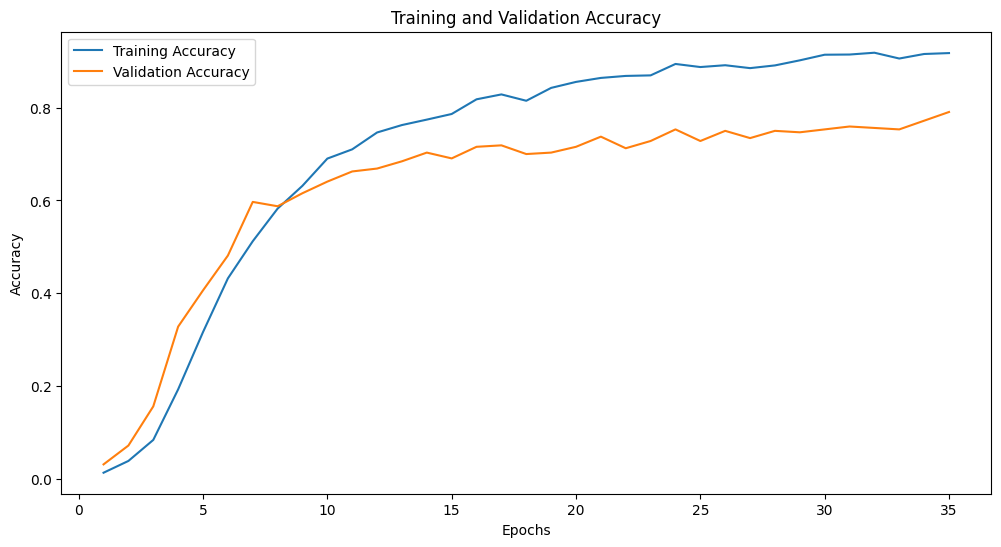

In [13]:
# Create an instance of the model
model = PitchDetectionModel()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(0.001),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

print("Fit model on training data")
history = model.fit(
  x=train_loader,
  epochs=35,
  verbose=1,
  validation_data=val_loader
)

import matplotlib.pyplot as plt

training_accuracy = history.history['sparse_categorical_accuracy']
validation_accuracy = history.history['val_sparse_categorical_accuracy']

epochs = range(1, len(training_accuracy) + 1)

# Plotting the accuracy graph
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_loader)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

10/10 [==============================] - 1s 39ms/step - loss: 2.1372 - sparse_categorical_accuracy: 0.6906
Test accuracy: 0.690625011920929, Test loss: 2.137176990509033


In [15]:
def qualitative_results_keras(model, data_loader, num_epochs):
    correct_per_label = {}
    number_of_labels = {}
    device = "/gpu:0" if tf.test.is_gpu_available() else "/cpu:0"

    with tf.device(device):
        for epoch in range(num_epochs):
            print('Epoch:', epoch)
            for i, (inputs, labels) in enumerate(data_loader):
                inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
                labels = tf.convert_to_tensor(labels, dtype=tf.int64)
                labels = tf.math.abs(labels)

                outputs = model(inputs, training=False)
                predicted = tf.math.argmax(outputs, axis=1)

                for j in labels:
                    j_item = j.numpy().item()
                    if j_item not in number_of_labels:
                        number_of_labels[j_item] = 1
                    else:
                        number_of_labels[j_item] += 1

                for label, prediction in zip(labels, predicted):
                    label_item = label.numpy().item()
                    prediction_item = prediction.numpy().item()
                    if prediction_item == label_item:
                        correct_per_label[label_item] = correct_per_label.get(label_item, 0) + 1

        print('Finished Training')
        print(correct_per_label)
        print(number_of_labels)

        for i in number_of_labels:
            if i not in correct_per_label:
                correct_per_label[i] = 0

        for i in correct_per_label:
            print("Label", i, "Accuracy:", correct_per_label[i] / float(number_of_labels[i]))

In [16]:
qualitative_results_keras(model, train_loader, 35)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Finished Training
{85: 805, 10: 980, 60: 1295, 33: 1190, 48: 805, 84: 735, 21: 1190, 54: 1120, 13: 945, 0: 630, 6: 875, 49: 1155, 52: 1260, 56: 1260, 17: 1155, 4: 525, 74: 980, 40: 1015, 63: 1120, 20: 1190, 44: 1015, 41: 1015, 7: 945, 22: 1190, 67: 1225, 64: 1155, 8: 910, 78: 735, 16: 1260, 14: 1050, 29: 1295, 87: 700, 32: 1050, 70: 1015, 65: 1050, 66: 980, 30: 945, 28: 945, 47: 1155, 24: 1155, 81: 665, 18: 1015, 51: 945, 34: 875, 61: 1120, 36: 980, 45: 1190, 57: 980, 42: 980, 62: 1085, 72: 1120, 38: 1225, 58: 875, 35: 1330, 68: 1050, 3: 805, 77: 700, 50: 875, 46: 1260, 5: 595, 27: 1610, 19: 1715, 15: 875, 86: 700, 11: 1050, 25: 1365, 55: 840, 53: 1190

In [17]:
qualitative_results_keras(model, val_loader, 35)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Finished Training
{35: 35, 39: 210, 10: 70, 63: 140, 27: 140, 71: 105, 46: 245, 85: 35, 26: 70, 13: 140, 56: 140, 2: 70, 45: 105, 31: 105, 38: 105, 66: 175, 25: 140, 68: 175, 69: 105, 37: 140, 55: 210, 32: 245, 81: 140, 24: 175, 49: 35, 29: 105, 61: 140, 50: 140, 51: 105, 53: 140, 52: 175, 76: 175, 23: 210, 15: 35, 14: 35, 83: 35, 20: 70, 36: 140, 33: 175, 34: 175, 16: 140, 3: 140, 62: 315, 43: 315, 65: 140, 60: 105, 44: 105, 79: 105, 18: 70, 73: 140, 30: 140, 77: 70, 75: 210, 59: 105, 47: 175, 82: 70, 17: 105, 54: 105, 22: 70, 19: 70, 5: 105, 42: 35, 28: 70, 48: 70, 80: 35, 64: 35, 67: 35, 70: 70, 21: 140, 7: 35, 40: 70, 57: 105, 41: 35, 58: 35, 74: 3